## Task 1: Aperture view (40 pts)
Write a function that outputs an image visualizing the light field as a set of aperture views. Assuming the size of the y and x dimensions of the light field are h and w, the aperture visualization should be an Nh×Nw picture composed of h×w sub-pictures representing the value of each pixel in each of the N × N views. You can add a one pixel boundary between apertures for visualization. You can choose the light field of your preference, some are provided, you can download more from http://lightfield.stanford.edu/lfs.html and http://web.media.mit.edu/~gordonw/SyntheticLightFields/index.php

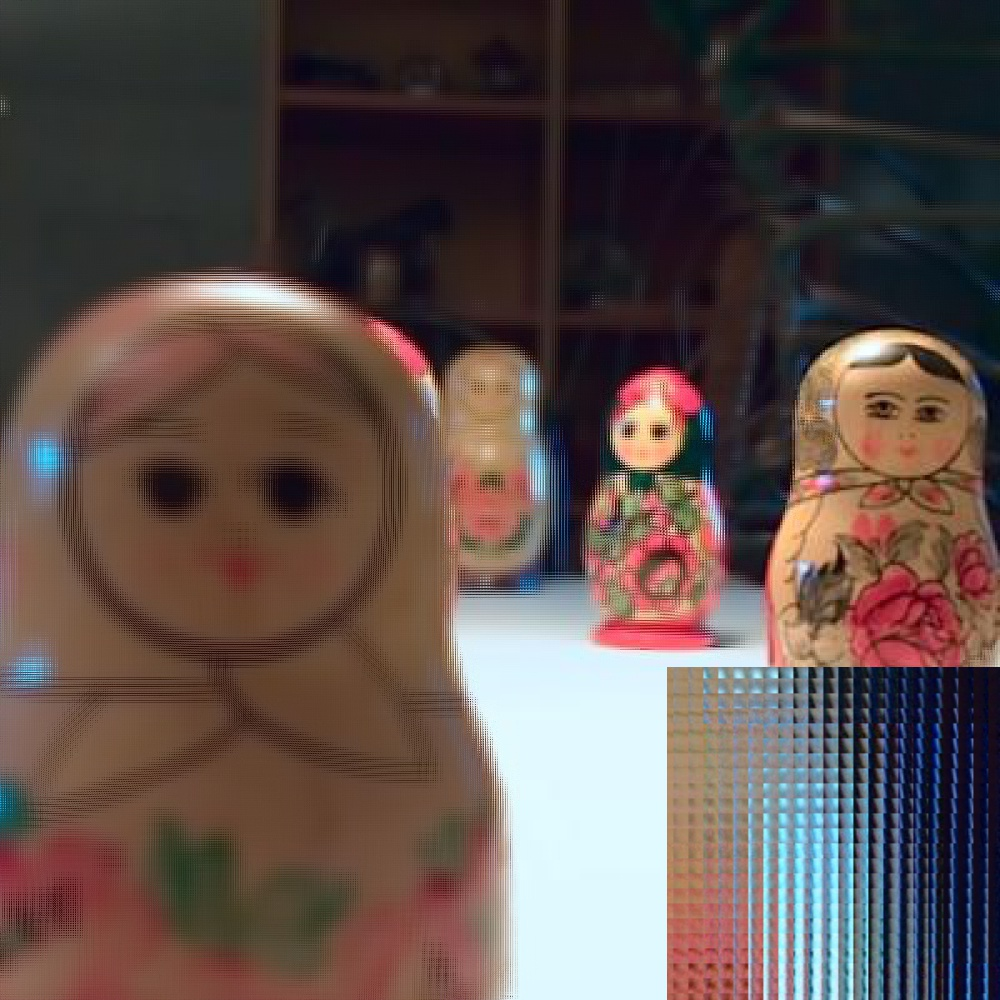

In [1]:
from IPython.display import Image
import numpy as np
import cv2
from lib.display_helper import *

def aperture_view(image, N):
    (h,w,c) = image.shape
    output = np.zeros_like(image)
    sh = h/N
    sw = w/N
    for i in range(N):
        for j in range(N):
            output[i::N,j::N] = image[sh*i:sh*(i+1), sw*j:sw*(j+1)]
    return output

matrioska_img = cv2.imread('data/9x9/matrioska.jpg');

output = aperture_view(matrioska_img, 9)
output_path = 'output/task1.jpg'
cv2.imwrite(output_path, output)

output_disp = output.copy()
zoom = cv2.resize(output_disp[1550:1750,1850:2050], (1200, 1200))
output_disp[-1200:,-1200:] = zoom
output_disp = cv2.resize(output_disp, (1000, 1000))
output_disp_path = 'output/task1_disp.jpg'
cv2.imwrite(output_disp_path, output_disp)
Image(output_disp_path)

## Task 2: light field slice (10 pts)
Load the images and plot for a central line of the light field, all the horizontal views. You have two
types of data sets, 9x9 and 17x17 images.The slices should have 9 or 17 lines, but you can scale it
up in that axis for easier visualisation. These are called 2D Epipolar Images. Do the same for the
vertical views. Try with different light fields. You only need to this for one line in this task.

In [2]:
def light_field_slice(image, N, line_index, line_axis, lf_index=None, lf_axis=None):
    if lf_index is None:
        lf_index = int(N/2)
    if lf_axis is None:
        lf_axis = line_axis

    if line_axis == 0:
        img = image.transpose((1,0,2))
    elif line_axis == 1:
        img = image.copy()
    else:
        raise NotImplementedError("axis should be 0 or 1")

    lines = []
    for i in range(N):
        if lf_axis == line_axis:
            lines.append(img[line_index*N+lf_index, i::N])
        else:
            lines.append(img[line_index*N+i, lf_index::N])
    
    lines = np.array(lines)
    
    if line_axis == 0:
        lines = lines.transpose((1,0,2))
        
    return lines

In [3]:
matrioska_img = cv2.imread('data/9x9/matrioska.jpg');
av_img = aperture_view(matrioska_img, 9)

line_i = av_img.shape[1]/(2*9)
scanlines = [ light_field_slice(av_img, 9, line_index, 1, i) for i in range(9)]
sl_size = (int(scanlines[0].shape[1]*1.5), scanlines[0].shape[0]*5)
scanlines = [ cv2.resize(sl, sl_size) for sl in scanlines ]
scanlines_disp = multiple_display([[sl] for sl in scanlines])
output_path = 'output/task2_horizontal.jpg'
cv2.imwrite(output_path, scanlines_disp)
Image(output_path)

NameError: name 'line_index' is not defined

In [ ]:
matrioska_img = cv2.imread('data/9x9/matrioska.jpg');
av_img = aperture_view(matrioska_img, 9)

line_i = av_img.shape[0]/(2*9)
scanlines = [ light_field_slice(av_img, 9, line_index, 0, i) for i in range(9)]
sl_size = (scanlines[0].shape[1]*8, int(scanlines[1].shape[0]*1.5))
scanlines = [ cv2.resize(sl, sl_size) for sl in scanlines ]
scanlines_disp = multiple_display([scanlines])
output_path = 'output/task2_vertical.jpg'
cv2.imwrite(output_path, scanlines_disp)
Image(output_path)